In [1]:
import numpy as np
total_no_of_events = '30_events'
sdi = np.load(f'/users2/local/Venkatesh/Generated_Data/25_subjects_new/SDI/{total_no_of_events}.npz')


In [2]:
surrogate_SDI = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects_new/SDI/surrogate_SDI_differenced.npz')
empirical_SDI = np.load('/users2/local/Venkatesh/Generated_Data/25_subjects_new/SDI/empirical_SDIndex_differenced.npz')

In [3]:
empirical_one_band = empirical_SDI['theta']
surrogate_one_band = surrogate_SDI['theta']


In [4]:
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu, rankdata, ttest_1samp
from tqdm.notebook import tqdm

n_subjects = 25
n_events = 30
n_roi = 360
n_surrogate = 19

test_stats = list()

for subject in tqdm(range(n_subjects)):
    event_level_p = list()


    for event in range(n_events):
        roi_level_p = list()

        
        for roi in range(n_roi):

            data_empirical = empirical_one_band[event, subject, roi]
            data_surrogate = surrogate_one_band[event, :, subject, roi]
            
            stat_test = sum(rankdata(np.abs(data_empirical - data_surrogate))*np.sign(data_empirical - data_surrogate))
            stat_test_normalized = stat_test / n_surrogate
            

            roi_level_p.append(stat_test_normalized)
        
        event_level_p.append(roi_level_p)
    
    test_stats.append(event_level_p)


  0%|          | 0/25 [00:00<?, ?it/s]

# Step 2: Test for effect of events

In [5]:
pvalues_step2 = list()
tvalues_step2 = list()

for sub in range(n_subjects):
    sub_wise_p = list()
    sub_wise_t = list()

    for roi in range(n_roi):
        data = np.array(test_stats)[sub, :, roi]

        t, p = ttest_1samp(data, popmean = 0)

        sub_wise_p.append(p)
        sub_wise_t.append(t)
    
    pvalues_step2.append(sub_wise_p)
    tvalues_step2.append(sub_wise_t)



In [ ]:

from nilearn.regions import signals_to_img_labels
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
path_Glasser = "/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz"

mnitemp = fetch_icbm152_2009()
mask_mni = image.load_img(mnitemp["mask"])
glasser_atlas = image.load_img(path_Glasser)

for i in range(n_subjects):

    thresholded_pvals = (np.array(pvalues_step2)[i] < 0.05) * tvalues_step2[i]
    signal = np.expand_dims(thresholded_pvals, axis =(0,2))


    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])

    plot = plotting.plot_img_on_surf(
        U0_brain, title = f'tvalues (uncorrected) for subj {i}', threshold = 0.1)

    plt.show()


## Step 3: Second level Model

In [ ]:
final_p, final_t = list(), []
for roi in range(n_roi):
    tvals, pvals = ttest_1samp(np.array(tvalues_step2)[:, roi], popmean=0)

    final_p.append(pvals)
    final_t.append(tvals)

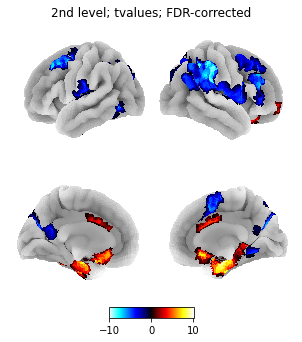

In [131]:

final_p_fdr = fdrcorrection(final_p)[1]



from nilearn.regions import signals_to_img_labels
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
path_Glasser = "/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz"

mnitemp = fetch_icbm152_2009()
mask_mni = image.load_img(mnitemp["mask"])
glasser_atlas = image.load_img(path_Glasser)

for i in range(1):

    thresholded_pvals = (np.array(final_p_fdr) < 0.001) * final_t
    signal = np.expand_dims(thresholded_pvals, axis =(0,2))


    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])

    plot = plotting.plot_img_on_surf(
        U0_brain, title = f'2nd level; tvalues; FDR-corrected', threshold=0.1)

    # U0_brain.to_filename('2nd_level_map.nii.gz')
    plt.show()

Permuting 9999 times...


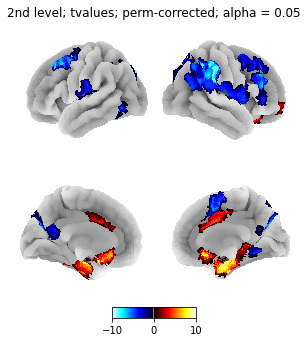

In [153]:
secondlevel_t, secondlevel_p, _ = mne.stats.permutation_t_test(np.array(np.array(tvalues_step2)))

from nilearn.regions import signals_to_img_labels
from nilearn.datasets import fetch_icbm152_2009
from nilearn import image, plotting
path_Glasser = "/homes/v20subra/S4B2/GSP/Glasser_masker.nii.gz"

mnitemp = fetch_icbm152_2009()
mask_mni = image.load_img(mnitemp["mask"])
glasser_atlas = image.load_img(path_Glasser)

for i in range(1):

    thresholded_tvals = (secondlevel_p < 0.05) * secondlevel_t

    signal = np.expand_dims(thresholded_tvals, axis =(0,2))


    U0_brain = signals_to_img_labels(signal, path_Glasser, mnitemp["mask"])

    plot = plotting.plot_img_on_surf(
        U0_brain, title = f'2nd level; tvalues; perm-corrected; alpha = 0.05', threshold=0.1)

    # U0_brain.to_filename('2nd_level_map_perm_corrected_stat.nii.gz')
    plt.show()

## More Stringent correction

In [206]:
import nilearn

# coord = nilearn.plotting.find_parcellation_cut_coords(glasser_atlas, label_hemisphere = 'left')

from sklearn.neighbors import kneighbors_graph
graph = kneighbors_graph(coord_left, n_neighbors=6, mode = 'distance').toarray()

adjacency = (graph>0) * 1
